Visualizing a few images from the CIFAR-10 dataset

100%|██████████| 170498071/170498071 [00:12<00:00, 13138378.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


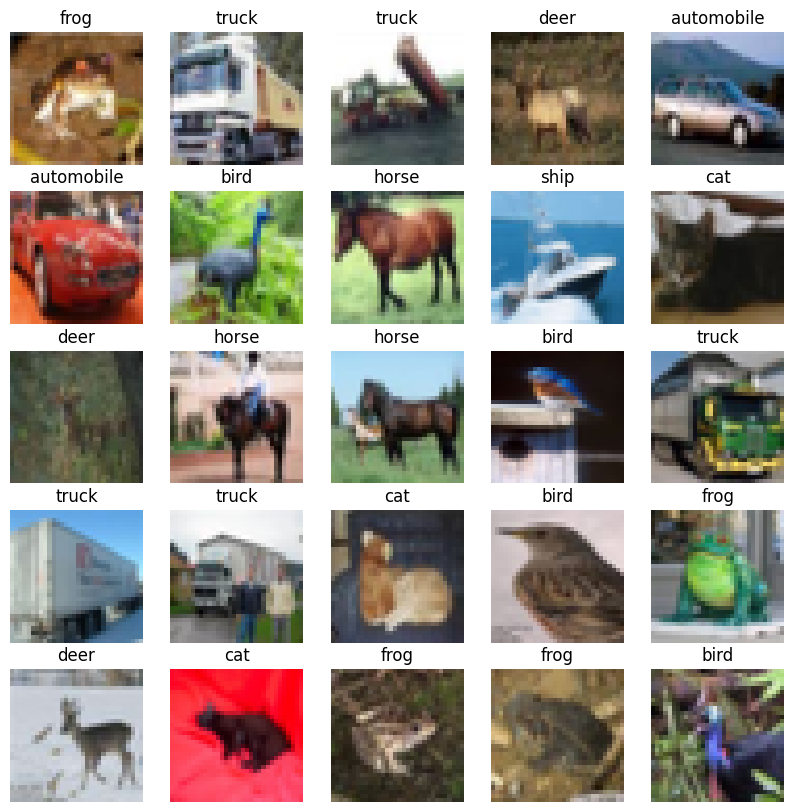

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Define the class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Load the CIFAR-10 dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define a function to display a grid of images from the dataset
def display_images_grid(images, titles, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(np.transpose(images[i*cols+j].numpy(), (1, 2, 0)))
            axs[i,j].set_title(class_names[titles[i*cols+j]])
            axs[i,j].axis('off')
    plt.show()

# Display a grid of 25 images from the dataset
images = []
titles = []
for i in range(25):
    image, label = cifar_dataset[i]
    images.append(image)
    titles.append(label)
display_images_grid(images, titles, 5, 5)

'DatasetFetcher' allows fetching and preparing data loaders for the CIFAR-10 dataset using PyTorch's DataLoader class. The class supports data augmentation and normalization. The data augmentation consists of random horizontal flip, random crop, and equalization of the image. The normalization is based on the mean and standard deviation of the training dataset. The code initializes the 'DatasetFetcher' object, adds data augmentation and normalization, and retrieves the training and testing data loaders. The batch_size parameter specifies the number of samples per batch, while size and padding parameters in dataAugmentation method control the size and padding of the random crop.

In [2]:
import torch
import multiprocessing
import torchvision
# import numpy as np
from torch.utils.data import DataLoader

class DatasetFetcher:
    
    def __init__(self, dataset="CIFAR10", batch_size=128):
        # Initialize the class with the specified dataset name and batch size
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.train_transformers = []
        self.test_transformers = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)

    def augmentData(self):
        # Add a transformer that randomly flips the image horizontally during training
        self.train_transformers.append(torchvision.transforms.RandomHorizontalFlip())
        # Add a transformer that randomly crops the image during training
        self.train_transformers.append(torchvision.transforms.RandomCrop(size=32, padding=3))
        # Add a transformer that equalizes the histogram of the image during both training and testing
        self.train_transformers.append(torchvision.transforms.functional.equalize)
        self.test_transformers.append(torchvision.transforms.functional.equalize)

    def __addToTensor(self):
        # Helper function to add a transformer that converts the image to a tensor during both training and testing
        self.train_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.ToTensor())
        
    def __loadTrainNormalizers(self):
        # Helper function to load the mean and standard deviation of the training dataset
        params = np.load("./trainNormalizedParameters.npz")
        return params['mean'], params['std']

    def addNormalizer(self):
        # Add a transformer that normalizes the image during both training and testing
        self.__addToTensor()
        trainingDataset = self.datasetObject(root="./data", train=True, download=True)
        trainData = trainingDataset.data/255.0
        mean = trainData.mean(axis=(0, 1, 2))
        std = trainData.std(axis=(0, 1, 2))
        np.savez("./trainNormalizedParameters", mean=mean, std=std)
        self.train_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
 
        # function to get train and test loaders
    def getLoaders(self):
        # check if train transformers are empty and add 'ToTensor' transformer
        if len(self.train_transformers) == 0:
            self.__addToTensor()
            
        # create training dataset using the 'train_transformers'
        train_dataset = self.datasetObject(
            root="./data", train=True, download=True,
            transform=torchvision.transforms.Compose(self.train_transformers)
        )
        
        # create testing dataset using the 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create train loader using the training dataset
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=self.workersAvailable
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return train_loader, test_loader

    # function to get test loader
    def getTestLoader(self):
        # get mean and std dev of train dataset
        mean, std = self.__loadTrainNormalizers()
        
        # append 'ToTensor' and 'Normalize' transformers to 'test_transformers'
        self.test_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        
        # create testing dataset using the updated 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return test_loader

# main code block
if __name__ == "__main__":
    # create an instance of DatasetFetcher class with CIFAR10 dataset and batch size of 128
    df = DatasetFetcher(dataset="CIFAR10", batch_size=128)
    
    # add transformations to the dataset
    df.augmentData()
    df.addNormalizer()
    
    # get train and test loaders using the added transformations
    train_loader, test_loader = df.getLoaders()

   

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified



Worked on the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py \\
C - Number of channels \\
F - Filter size \\
K - Kernel size \\
P - Pool size \\

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
         # Batch normalization layer after the first convolution
        self.bn1 = nn.BatchNorm2d(planes)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        # Batch normalization layer after the second convolution
        self.bn2 = nn.BatchNorm2d(planes)

         # Shortcuts are used to add the input to the output of the residual block
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
           # If the input and output dimensions are not the same, use a convolutional layer to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
      # Apply the first convolutional layer, followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the second convolutional layer, followed by batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
         # Apply ReLU activation to the output
        out = F.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
      # Call the superclass constructor to initialize the nn.Module
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

         # Create the first convolutional layer and batch normalization layer
        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        # Create the remaining layers using the specified number of blocks
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        # Create the output layer
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        # Set the path to save the model
        self.path = "./saved_model.pt"
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
      # Create a list of strides for each block in the layer
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        # Create each block in the layer
        for stride in strides:
           # Append the block to the list of blocks in the layer
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            # Update the number of input channels for the next bloc
            self.in_planes = planes
            # Return the layer as a sequential module
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply the first convolutional layer followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the remaining layers in the network
        for layer in self.layers:
            out = layer(out)
        # Apply average pooling with kernel size P
        out = F.avg_pool2d(out, self.P)
        # Flatten the output tensor
        out = out.view(out.size(0), -1)
        # Apply the final linear layer to produce the output tensor
        out = self.linear(out)
        # Return the output tensor
        return out

     #Define a function to save the model to disk
    def saveToDisk(self):
      torch.save(self.state_dict(), self.path)

    #Define a function to load the model from disk
    def loadFromDisk(self):
      self.load_state_dict(torch.load(self.path))

def resnet_model():
  B=[3,3,2,3]
  C=[64,128,128,256]
  F=[3,3,3,3]
  K=[1,1,1,1]
  P=4
  N=len(B)
  return ResNet(N, B, C, F, K, P)

In [4]:
import torch
# Set random seed to ensure reproducibility
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
model = resnet_model()
model = model.to(device)
# Count the number of trainable parameters in the model
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Print the number of trainable parameters
print("Number of trainable parameters:",trainable_parameters)




Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
Number of trainable parameters: 4935242


To determine the model's best accuracy, we run it for 300 epochs. After that, accuracy becomes almost constant. We specify the following parameters: learning rate, weight decay, and kind of optimizer to be employed (Adam, Adagrad, and AdaDelta), with Adadelta providing the greatest accuracy. A cosine annealing scheduler was used to determine the learning rate for each parameter group.

In [6]:
# Define number of epochs
EPOCHS = 300
# Initialize global best accuracy
globalBestAccuracy = 0.0
# Create empty lists to store training and testing losses and accuracies
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [7]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.01
weightDecay = 0.0001
optimizer = torch.optim.Adagrad(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Number of Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model parameters are out of range")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Now we train and test the model for 300 epochs.

In [8]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

# Training loop
for i in tqdm(range(EPOCHS)):   # Loop over the number of epochs
    for phase in ['train', 'test']:  # Loop over the training and test phases
        if phase == "train": # Set the loader and model mode based on the phase
            loader = train_loader
            model,optimizer= train(model,loader,optimizer)
        else:
            loader = test_loader
            #test
            model.eval()
        runningLoss = 0.0  # Initialize the running loss and corrects
        runningCorrects = 0
        for images, labels in loader:  # Loop over the batches of data
            images = images.to(device)  # Move images and labels to device
            labels = labels.to(device)
            output = model(images)  # Forward pass through the model
            loss = lossFunction(output, labels)  # Compute the loss
            predicted_labels = torch.argmax(output, dim=1)  # Get the predicted labels
            runningLoss += loss.item()  # Update the running loss and corrects
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":  # Backward pass and optimization for training phase
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)  # Compute the epoch loss and accuracy
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":  # Update the scheduler and training statistics
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:  # Update the testing statistics and save the model if it is the best so far
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    # Print the statistics for the current epoch
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))


  0%|          | 1/300 [00:58<4:52:22, 58.67s/it]

Training Loss : 2.3884211111450195, Testing Loss : 2.3702305480957033, Training Accuracy : 0.11528, Testing Accuracy : 0.1268


  1%|          | 2/300 [01:51<4:33:22, 55.04s/it]

Training Loss : 2.202468250732422, Testing Loss : 2.1166010047912596, Training Accuracy : 0.16888, Testing Accuracy : 0.2028


  1%|          | 3/300 [02:43<4:26:11, 53.77s/it]

Training Loss : 2.0622393923950195, Testing Loss : 2.0211806812286377, Training Accuracy : 0.21982, Testing Accuracy : 0.2538


  1%|▏         | 4/300 [03:35<4:22:34, 53.23s/it]

Training Loss : 1.9280065966796875, Testing Loss : 1.8876799076080322, Training Accuracy : 0.27744, Testing Accuracy : 0.3127


  2%|▏         | 5/300 [04:28<4:21:26, 53.18s/it]

Training Loss : 1.768500181427002, Testing Loss : 1.6588580307006835, Training Accuracy : 0.35332, Testing Accuracy : 0.4075


  2%|▏         | 6/300 [05:21<4:20:14, 53.11s/it]

Training Loss : 1.6227647576904296, Testing Loss : 1.5999904062271117, Training Accuracy : 0.41122, Testing Accuracy : 0.4204


  2%|▏         | 7/300 [06:14<4:19:12, 53.08s/it]

Training Loss : 1.4845968154907228, Testing Loss : 1.461361291885376, Training Accuracy : 0.46394, Testing Accuracy : 0.4773


  3%|▎         | 8/300 [07:08<4:18:31, 53.12s/it]

Training Loss : 1.3836842086791992, Testing Loss : 1.3416731672286988, Training Accuracy : 0.50232, Testing Accuracy : 0.5238


  3%|▎         | 9/300 [08:00<4:16:36, 52.91s/it]

Training Loss : 1.2856498291015626, Testing Loss : 1.3438318183898925, Training Accuracy : 0.53772, Testing Accuracy : 0.5279


  3%|▎         | 10/300 [08:52<4:14:24, 52.64s/it]

Training Loss : 1.1925700077819825, Testing Loss : 1.23055103931427, Training Accuracy : 0.57642, Testing Accuracy : 0.5733


  4%|▎         | 11/300 [09:44<4:12:27, 52.41s/it]

Training Loss : 1.103663391571045, Testing Loss : 1.101609983444214, Training Accuracy : 0.60996, Testing Accuracy : 0.6136


  4%|▍         | 12/300 [10:36<4:10:56, 52.28s/it]

Training Loss : 1.0319686631774903, Testing Loss : 1.06589723777771, Training Accuracy : 0.63532, Testing Accuracy : 0.6184


  4%|▍         | 13/300 [11:29<4:10:36, 52.39s/it]

Training Loss : 0.9698241397094727, Testing Loss : 1.0280910367012024, Training Accuracy : 0.65716, Testing Accuracy : 0.6432


  5%|▍         | 14/300 [12:21<4:09:30, 52.35s/it]

Training Loss : 0.9240307217407226, Testing Loss : 0.9110326169013977, Training Accuracy : 0.6756, Testing Accuracy : 0.6848


  5%|▌         | 15/300 [13:13<4:08:21, 52.28s/it]

Training Loss : 0.8597600273132324, Testing Loss : 0.9192307415008545, Training Accuracy : 0.6998, Testing Accuracy : 0.6829


  5%|▌         | 16/300 [14:06<4:07:51, 52.36s/it]

Training Loss : 0.844363779296875, Testing Loss : 0.8850604804039002, Training Accuracy : 0.70282, Testing Accuracy : 0.6913


  6%|▌         | 17/300 [14:58<4:07:26, 52.46s/it]

Training Loss : 0.800923699798584, Testing Loss : 0.8405938844680786, Training Accuracy : 0.7221, Testing Accuracy : 0.7108


  6%|▌         | 18/300 [15:51<4:07:06, 52.58s/it]

Training Loss : 0.7788221739196778, Testing Loss : 0.8322764720916748, Training Accuracy : 0.72606, Testing Accuracy : 0.7102


  6%|▋         | 19/300 [16:44<4:06:22, 52.61s/it]

Training Loss : 0.7401714817810059, Testing Loss : 0.8312376999855041, Training Accuracy : 0.7409, Testing Accuracy : 0.7161


  7%|▋         | 20/300 [17:36<4:05:29, 52.61s/it]

Training Loss : 0.7154168897247315, Testing Loss : 0.7531944072723389, Training Accuracy : 0.7502, Testing Accuracy : 0.7419


  7%|▋         | 21/300 [18:29<4:04:01, 52.48s/it]

Training Loss : 0.675685998916626, Testing Loss : 0.7268455628395081, Training Accuracy : 0.76436, Testing Accuracy : 0.7503


  7%|▋         | 22/300 [19:20<4:02:05, 52.25s/it]

Training Loss : 0.6534797072601318, Testing Loss : 0.7395457431793213, Training Accuracy : 0.77334, Testing Accuracy : 0.749


  8%|▊         | 23/300 [20:12<4:00:26, 52.08s/it]

Training Loss : 0.6359164253997803, Testing Loss : 0.7448285666465759, Training Accuracy : 0.77606, Testing Accuracy : 0.7406


  8%|▊         | 24/300 [21:04<3:59:00, 51.96s/it]

Training Loss : 0.6138977344512939, Testing Loss : 0.7291242193222046, Training Accuracy : 0.7865, Testing Accuracy : 0.7557


  8%|▊         | 25/300 [21:55<3:57:41, 51.86s/it]

Training Loss : 0.6049083020782471, Testing Loss : 0.6692601798057556, Training Accuracy : 0.78888, Testing Accuracy : 0.7704


  9%|▊         | 26/300 [22:47<3:56:22, 51.76s/it]

Training Loss : 0.5829906833648681, Testing Loss : 0.6970200891494751, Training Accuracy : 0.79582, Testing Accuracy : 0.7665


  9%|▉         | 27/300 [23:38<3:54:48, 51.61s/it]

Training Loss : 0.5705924913787842, Testing Loss : 0.6520652678489685, Training Accuracy : 0.79952, Testing Accuracy : 0.7779


  9%|▉         | 28/300 [24:29<3:53:39, 51.54s/it]

Training Loss : 0.5397951795959472, Testing Loss : 0.645672502708435, Training Accuracy : 0.81058, Testing Accuracy : 0.7815


 10%|▉         | 29/300 [25:21<3:52:24, 51.46s/it]

Training Loss : 0.5354784687042237, Testing Loss : 0.674496355342865, Training Accuracy : 0.81376, Testing Accuracy : 0.772


 10%|█         | 30/300 [26:12<3:51:42, 51.49s/it]

Training Loss : 0.5207910080718994, Testing Loss : 0.634777977180481, Training Accuracy : 0.8175, Testing Accuracy : 0.787


 10%|█         | 31/300 [27:04<3:50:49, 51.48s/it]

Training Loss : 0.5050768981170655, Testing Loss : 0.6397518754005432, Training Accuracy : 0.82456, Testing Accuracy : 0.7843


 11%|█         | 32/300 [27:55<3:50:07, 51.52s/it]

Training Loss : 0.48865956718444825, Testing Loss : 0.6274852589607238, Training Accuracy : 0.82812, Testing Accuracy : 0.7916


 11%|█         | 33/300 [28:47<3:50:08, 51.72s/it]

Training Loss : 0.4848307189178467, Testing Loss : 0.6311383890151978, Training Accuracy : 0.83198, Testing Accuracy : 0.7893


 11%|█▏        | 34/300 [29:40<3:49:50, 51.84s/it]

Training Loss : 0.4842683612823486, Testing Loss : 0.6276197127342225, Training Accuracy : 0.83118, Testing Accuracy : 0.7918


 12%|█▏        | 35/300 [30:32<3:49:14, 51.90s/it]

Training Loss : 0.45879990127563475, Testing Loss : 0.5990337206840515, Training Accuracy : 0.84004, Testing Accuracy : 0.801


 12%|█▏        | 36/300 [31:25<3:49:37, 52.19s/it]

Training Loss : 0.43390781288146973, Testing Loss : 0.6037536361694336, Training Accuracy : 0.84838, Testing Accuracy : 0.8033


 12%|█▏        | 37/300 [32:17<3:48:42, 52.18s/it]

Training Loss : 0.4398789825439453, Testing Loss : 0.6161483039855957, Training Accuracy : 0.84582, Testing Accuracy : 0.7908


 13%|█▎        | 38/300 [33:09<3:48:18, 52.29s/it]

Training Loss : 0.42894713085174563, Testing Loss : 0.5917215331077575, Training Accuracy : 0.84968, Testing Accuracy : 0.8011


 13%|█▎        | 39/300 [34:01<3:47:15, 52.24s/it]

Training Loss : 0.4135996377182007, Testing Loss : 0.5870566962242126, Training Accuracy : 0.85604, Testing Accuracy : 0.8098


 13%|█▎        | 40/300 [34:54<3:47:21, 52.47s/it]

Training Loss : 0.40084587059021, Testing Loss : 0.5562037817001343, Training Accuracy : 0.85912, Testing Accuracy : 0.8118


 14%|█▎        | 41/300 [35:46<3:45:23, 52.21s/it]

Training Loss : 0.38277627475738524, Testing Loss : 0.5953391541481018, Training Accuracy : 0.86506, Testing Accuracy : 0.8065


 14%|█▍        | 42/300 [36:38<3:44:21, 52.18s/it]

Training Loss : 0.37599233016967776, Testing Loss : 0.573152762889862, Training Accuracy : 0.86808, Testing Accuracy : 0.8095


 14%|█▍        | 43/300 [37:30<3:42:50, 52.03s/it]

Training Loss : 0.3665443913269043, Testing Loss : 0.5719542675018311, Training Accuracy : 0.87034, Testing Accuracy : 0.811


 15%|█▍        | 44/300 [38:21<3:41:30, 51.92s/it]

Training Loss : 0.3595400734329224, Testing Loss : 0.5482237273216247, Training Accuracy : 0.87252, Testing Accuracy : 0.8181


 15%|█▌        | 45/300 [39:13<3:40:34, 51.90s/it]

Training Loss : 0.3474038412475586, Testing Loss : 0.5703939842224122, Training Accuracy : 0.87862, Testing Accuracy : 0.8134


 15%|█▌        | 46/300 [40:05<3:38:59, 51.73s/it]

Training Loss : 0.3416463996887207, Testing Loss : 0.5700277878761292, Training Accuracy : 0.87834, Testing Accuracy : 0.8177


 16%|█▌        | 47/300 [40:56<3:38:04, 51.72s/it]

Training Loss : 0.3413736362838745, Testing Loss : 0.5861890133857727, Training Accuracy : 0.8806, Testing Accuracy : 0.8088


 16%|█▌        | 48/300 [41:48<3:37:02, 51.68s/it]

Training Loss : 0.32553758895874024, Testing Loss : 0.5827967105865478, Training Accuracy : 0.88818, Testing Accuracy : 0.8157


 16%|█▋        | 49/300 [42:40<3:36:27, 51.74s/it]

Training Loss : 0.31890703105926516, Testing Loss : 0.5725751582145691, Training Accuracy : 0.88684, Testing Accuracy : 0.8138


 17%|█▋        | 50/300 [43:31<3:35:15, 51.66s/it]

Training Loss : 0.3091779063796997, Testing Loss : 0.5877253588676452, Training Accuracy : 0.89124, Testing Accuracy : 0.8171


 17%|█▋        | 51/300 [44:23<3:35:07, 51.84s/it]

Training Loss : 0.31216386169433596, Testing Loss : 0.5630203506469726, Training Accuracy : 0.89004, Testing Accuracy : 0.8195


 17%|█▋        | 52/300 [45:15<3:33:45, 51.72s/it]

Training Loss : 0.295401266784668, Testing Loss : 0.5799802932739258, Training Accuracy : 0.89496, Testing Accuracy : 0.8232


 18%|█▊        | 53/300 [46:07<3:33:35, 51.89s/it]

Training Loss : 0.2887731796646118, Testing Loss : 0.5723706864356994, Training Accuracy : 0.89828, Testing Accuracy : 0.8194


 18%|█▊        | 54/300 [47:00<3:33:20, 52.03s/it]

Training Loss : 0.2754110549354553, Testing Loss : 0.5524720984458923, Training Accuracy : 0.90336, Testing Accuracy : 0.8294


 18%|█▊        | 55/300 [47:51<3:32:01, 51.92s/it]

Training Loss : 0.2712040561676025, Testing Loss : 0.5761159232139588, Training Accuracy : 0.90396, Testing Accuracy : 0.8266


 19%|█▊        | 56/300 [48:44<3:31:56, 52.12s/it]

Training Loss : 0.2702472353172302, Testing Loss : 0.5599557821273804, Training Accuracy : 0.90468, Testing Accuracy : 0.8265


 19%|█▉        | 57/300 [49:36<3:31:00, 52.10s/it]

Training Loss : 0.2550355452346802, Testing Loss : 0.538878520488739, Training Accuracy : 0.90958, Testing Accuracy : 0.8311


 19%|█▉        | 58/300 [50:28<3:30:39, 52.23s/it]

Training Loss : 0.24589696893692017, Testing Loss : 0.5665896724700927, Training Accuracy : 0.91174, Testing Accuracy : 0.8253


 20%|█▉        | 59/300 [51:21<3:29:57, 52.27s/it]

Training Loss : 0.23781001489639284, Testing Loss : 0.5831851497650147, Training Accuracy : 0.91528, Testing Accuracy : 0.8265


 20%|██        | 60/300 [52:12<3:28:22, 52.10s/it]

Training Loss : 0.2406093500137329, Testing Loss : 0.5762474813461304, Training Accuracy : 0.91476, Testing Accuracy : 0.8244


 20%|██        | 61/300 [53:04<3:26:35, 51.87s/it]

Training Loss : 0.23818047672271728, Testing Loss : 0.588784280014038, Training Accuracy : 0.9149, Testing Accuracy : 0.8259


 21%|██        | 62/300 [53:56<3:25:40, 51.85s/it]

Training Loss : 0.233865331363678, Testing Loss : 0.5647659784317016, Training Accuracy : 0.9168, Testing Accuracy : 0.8271


 21%|██        | 63/300 [54:47<3:24:16, 51.72s/it]

Training Loss : 0.22603886493682862, Testing Loss : 0.5854967034339905, Training Accuracy : 0.9199, Testing Accuracy : 0.8284


 21%|██▏       | 64/300 [55:39<3:23:21, 51.70s/it]

Training Loss : 0.21627068567276, Testing Loss : 0.5770131244659423, Training Accuracy : 0.92372, Testing Accuracy : 0.8305


 22%|██▏       | 65/300 [56:31<3:23:02, 51.84s/it]

Training Loss : 0.21327334020614624, Testing Loss : 0.5657282304763794, Training Accuracy : 0.9238, Testing Accuracy : 0.8328


 22%|██▏       | 66/300 [57:22<3:21:48, 51.75s/it]

Training Loss : 0.1933389595413208, Testing Loss : 0.5862435528755188, Training Accuracy : 0.93086, Testing Accuracy : 0.8333


 22%|██▏       | 67/300 [58:14<3:20:57, 51.75s/it]

Training Loss : 0.19001162380218506, Testing Loss : 0.5932624168395996, Training Accuracy : 0.9322, Testing Accuracy : 0.8323


 23%|██▎       | 68/300 [59:05<3:19:19, 51.55s/it]

Training Loss : 0.18999434129714965, Testing Loss : 0.5968521605491638, Training Accuracy : 0.93158, Testing Accuracy : 0.838


 23%|██▎       | 69/300 [59:57<3:18:49, 51.64s/it]

Training Loss : 0.19850674503326415, Testing Loss : 0.610104412651062, Training Accuracy : 0.92864, Testing Accuracy : 0.8271


 23%|██▎       | 70/300 [1:00:49<3:17:45, 51.59s/it]

Training Loss : 0.19048231121063233, Testing Loss : 0.605135682296753, Training Accuracy : 0.9325, Testing Accuracy : 0.8355


 24%|██▎       | 71/300 [1:01:40<3:16:48, 51.56s/it]

Training Loss : 0.18125906460762023, Testing Loss : 0.6041622712135315, Training Accuracy : 0.93626, Testing Accuracy : 0.8315


 24%|██▍       | 72/300 [1:02:32<3:15:52, 51.55s/it]

Training Loss : 0.17168159375190734, Testing Loss : 0.5996887484550476, Training Accuracy : 0.93818, Testing Accuracy : 0.8343


 24%|██▍       | 73/300 [1:03:23<3:15:23, 51.65s/it]

Training Loss : 0.16445544103622436, Testing Loss : 0.607671307849884, Training Accuracy : 0.94104, Testing Accuracy : 0.8367


 25%|██▍       | 74/300 [1:04:15<3:14:02, 51.51s/it]

Training Loss : 0.16809141745567321, Testing Loss : 0.5966894683837891, Training Accuracy : 0.94062, Testing Accuracy : 0.8381


 25%|██▌       | 75/300 [1:05:07<3:13:37, 51.64s/it]

Training Loss : 0.1680194830417633, Testing Loss : 0.6220281606674194, Training Accuracy : 0.94012, Testing Accuracy : 0.8346


 25%|██▌       | 76/300 [1:05:59<3:13:37, 51.86s/it]

Training Loss : 0.1544643433380127, Testing Loss : 0.6132564238548279, Training Accuracy : 0.9453, Testing Accuracy : 0.8359


 26%|██▌       | 77/300 [1:06:50<3:12:15, 51.73s/it]

Training Loss : 0.14898807792663574, Testing Loss : 0.599928370666504, Training Accuracy : 0.9479, Testing Accuracy : 0.8403


 26%|██▌       | 78/300 [1:07:42<3:11:48, 51.84s/it]

Training Loss : 0.13957144258499146, Testing Loss : 0.6357838228225708, Training Accuracy : 0.9499, Testing Accuracy : 0.8393


 26%|██▋       | 79/300 [1:08:34<3:10:15, 51.65s/it]

Training Loss : 0.13550316718101502, Testing Loss : 0.6184715151786804, Training Accuracy : 0.95176, Testing Accuracy : 0.8385


 27%|██▋       | 80/300 [1:09:26<3:09:53, 51.79s/it]

Training Loss : 0.1380079822063446, Testing Loss : 0.6311160616397857, Training Accuracy : 0.95122, Testing Accuracy : 0.8372


 27%|██▋       | 81/300 [1:10:17<3:08:40, 51.69s/it]

Training Loss : 0.1344415599155426, Testing Loss : 0.6320677363395691, Training Accuracy : 0.95172, Testing Accuracy : 0.84


 27%|██▋       | 82/300 [1:11:10<3:08:36, 51.91s/it]

Training Loss : 0.1305165659713745, Testing Loss : 0.6256313337326049, Training Accuracy : 0.95268, Testing Accuracy : 0.8433


 28%|██▊       | 83/300 [1:12:02<3:08:24, 52.10s/it]

Training Loss : 0.12185402830123901, Testing Loss : 0.6242495221138, Training Accuracy : 0.95698, Testing Accuracy : 0.843


 28%|██▊       | 84/300 [1:12:55<3:08:35, 52.39s/it]

Training Loss : 0.120947366065979, Testing Loss : 0.6374632822990417, Training Accuracy : 0.95678, Testing Accuracy : 0.8374


 28%|██▊       | 85/300 [1:13:48<3:08:36, 52.63s/it]

Training Loss : 0.11804308269023896, Testing Loss : 0.615245903301239, Training Accuracy : 0.95822, Testing Accuracy : 0.8423


 29%|██▊       | 86/300 [1:14:41<3:07:41, 52.62s/it]

Training Loss : 0.10724697625637054, Testing Loss : 0.6450302887916565, Training Accuracy : 0.9628, Testing Accuracy : 0.8419


 29%|██▉       | 87/300 [1:15:33<3:06:19, 52.48s/it]

Training Loss : 0.1069277192401886, Testing Loss : 0.6409624066352845, Training Accuracy : 0.96206, Testing Accuracy : 0.8451


 29%|██▉       | 88/300 [1:16:25<3:04:30, 52.22s/it]

Training Loss : 0.10591519814014434, Testing Loss : 0.6818410310983658, Training Accuracy : 0.9621, Testing Accuracy : 0.8395


 30%|██▉       | 89/300 [1:17:17<3:03:44, 52.25s/it]

Training Loss : 0.10626019432544709, Testing Loss : 0.6617370182037353, Training Accuracy : 0.96276, Testing Accuracy : 0.8409


 30%|███       | 90/300 [1:18:09<3:02:44, 52.21s/it]

Training Loss : 0.10674900721549987, Testing Loss : 0.658657077729702, Training Accuracy : 0.96272, Testing Accuracy : 0.8437


 30%|███       | 91/300 [1:19:02<3:02:27, 52.38s/it]

Training Loss : 0.10007307520389556, Testing Loss : 0.6696704285621643, Training Accuracy : 0.96422, Testing Accuracy : 0.8418


 31%|███       | 92/300 [1:19:54<3:00:51, 52.17s/it]

Training Loss : 0.10228552695274352, Testing Loss : 0.6474525879859925, Training Accuracy : 0.96362, Testing Accuracy : 0.8446


 31%|███       | 93/300 [1:20:46<2:59:59, 52.17s/it]

Training Loss : 0.09871696501731872, Testing Loss : 0.6565345335960389, Training Accuracy : 0.96514, Testing Accuracy : 0.8444


 31%|███▏      | 94/300 [1:21:37<2:57:59, 51.84s/it]

Training Loss : 0.09400088537216186, Testing Loss : 0.6666286903858185, Training Accuracy : 0.96696, Testing Accuracy : 0.8433


 32%|███▏      | 95/300 [1:22:28<2:56:34, 51.68s/it]

Training Loss : 0.093662946600914, Testing Loss : 0.6699073448181152, Training Accuracy : 0.96606, Testing Accuracy : 0.8441


 32%|███▏      | 96/300 [1:23:20<2:55:45, 51.70s/it]

Training Loss : 0.09293431550979614, Testing Loss : 0.671150751209259, Training Accuracy : 0.96614, Testing Accuracy : 0.8449


 32%|███▏      | 97/300 [1:24:12<2:55:14, 51.79s/it]

Training Loss : 0.08809554506778718, Testing Loss : 0.6860489235877991, Training Accuracy : 0.96828, Testing Accuracy : 0.8403


 33%|███▎      | 98/300 [1:25:04<2:54:45, 51.91s/it]

Training Loss : 0.08395484226226807, Testing Loss : 0.6578572815895081, Training Accuracy : 0.97002, Testing Accuracy : 0.8448


 33%|███▎      | 99/300 [1:25:56<2:53:35, 51.82s/it]

Training Loss : 0.07960091728925706, Testing Loss : 0.6821693429946899, Training Accuracy : 0.97212, Testing Accuracy : 0.8432


 33%|███▎      | 100/300 [1:26:48<2:52:58, 51.89s/it]

Training Loss : 0.07764307235479355, Testing Loss : 0.6822944550514222, Training Accuracy : 0.97278, Testing Accuracy : 0.8443


 34%|███▎      | 101/300 [1:27:39<2:51:29, 51.71s/it]

Training Loss : 0.07407134767532349, Testing Loss : 0.6768907229423523, Training Accuracy : 0.97402, Testing Accuracy : 0.8461


 34%|███▍      | 102/300 [1:28:31<2:50:54, 51.79s/it]

Training Loss : 0.0736934481215477, Testing Loss : 0.6700423836708069, Training Accuracy : 0.9739, Testing Accuracy : 0.8485


 34%|███▍      | 103/300 [1:29:23<2:50:04, 51.80s/it]

Training Loss : 0.07408680912733077, Testing Loss : 0.6956902141571045, Training Accuracy : 0.9744, Testing Accuracy : 0.8469


 35%|███▍      | 104/300 [1:30:14<2:48:46, 51.67s/it]

Training Loss : 0.07458373089075089, Testing Loss : 0.706140284538269, Training Accuracy : 0.97312, Testing Accuracy : 0.8463


 35%|███▌      | 105/300 [1:31:07<2:48:38, 51.89s/it]

Training Loss : 0.0666088881111145, Testing Loss : 0.710616792678833, Training Accuracy : 0.97652, Testing Accuracy : 0.8443


 35%|███▌      | 106/300 [1:32:00<2:48:39, 52.16s/it]

Training Loss : 0.07325795849323273, Testing Loss : 0.7381795604705811, Training Accuracy : 0.97436, Testing Accuracy : 0.8428


 36%|███▌      | 107/300 [1:32:52<2:48:24, 52.35s/it]

Training Loss : 0.06708968729972839, Testing Loss : 0.7224213754653931, Training Accuracy : 0.97668, Testing Accuracy : 0.8412


 36%|███▌      | 108/300 [1:33:45<2:47:33, 52.36s/it]

Training Loss : 0.06665465265274048, Testing Loss : 0.7244288673400879, Training Accuracy : 0.97616, Testing Accuracy : 0.8452


 36%|███▋      | 109/300 [1:34:38<2:47:07, 52.50s/it]

Training Loss : 0.06321044808745384, Testing Loss : 0.7013999666213989, Training Accuracy : 0.97784, Testing Accuracy : 0.8493


 37%|███▋      | 110/300 [1:35:31<2:46:47, 52.67s/it]

Training Loss : 0.05837156087636947, Testing Loss : 0.7231448238372803, Training Accuracy : 0.9796, Testing Accuracy : 0.8466


 37%|███▋      | 111/300 [1:36:23<2:45:41, 52.60s/it]

Training Loss : 0.05544410052061081, Testing Loss : 0.7127493869781494, Training Accuracy : 0.98062, Testing Accuracy : 0.8447


 37%|███▋      | 112/300 [1:37:15<2:44:24, 52.47s/it]

Training Loss : 0.05850356382131577, Testing Loss : 0.7518386371612549, Training Accuracy : 0.9792, Testing Accuracy : 0.845


 38%|███▊      | 113/300 [1:38:07<2:42:36, 52.17s/it]

Training Loss : 0.05713641184926033, Testing Loss : 0.7363661198139191, Training Accuracy : 0.97954, Testing Accuracy : 0.8462


 38%|███▊      | 114/300 [1:38:58<2:41:20, 52.04s/it]

Training Loss : 0.054280810668468474, Testing Loss : 0.7352902442932129, Training Accuracy : 0.98048, Testing Accuracy : 0.8472


 38%|███▊      | 115/300 [1:39:50<2:40:06, 51.93s/it]

Training Loss : 0.0545537967300415, Testing Loss : 0.7315757613182068, Training Accuracy : 0.98076, Testing Accuracy : 0.85


 39%|███▊      | 116/300 [1:40:42<2:39:32, 52.03s/it]

Training Loss : 0.05076109505057335, Testing Loss : 0.7478003917694092, Training Accuracy : 0.9826, Testing Accuracy : 0.8487


 39%|███▉      | 117/300 [1:41:34<2:38:15, 51.89s/it]

Training Loss : 0.050047621529102325, Testing Loss : 0.7309044345855713, Training Accuracy : 0.98176, Testing Accuracy : 0.8539


 39%|███▉      | 118/300 [1:42:26<2:37:33, 51.94s/it]

Training Loss : 0.047737701238393784, Testing Loss : 0.7538218222618103, Training Accuracy : 0.98364, Testing Accuracy : 0.8486


 40%|███▉      | 119/300 [1:43:19<2:37:15, 52.13s/it]

Training Loss : 0.046685389256477354, Testing Loss : 0.7600226893424987, Training Accuracy : 0.98352, Testing Accuracy : 0.8494


 40%|████      | 120/300 [1:44:10<2:35:45, 51.92s/it]

Training Loss : 0.04627352619290352, Testing Loss : 0.7278884784698486, Training Accuracy : 0.98424, Testing Accuracy : 0.8515


 40%|████      | 121/300 [1:45:02<2:35:16, 52.05s/it]

Training Loss : 0.04839405645251274, Testing Loss : 0.7689215302944183, Training Accuracy : 0.98264, Testing Accuracy : 0.8507


 41%|████      | 122/300 [1:45:54<2:33:58, 51.90s/it]

Training Loss : 0.046113695765733716, Testing Loss : 0.7620363780975342, Training Accuracy : 0.98394, Testing Accuracy : 0.8535


 41%|████      | 123/300 [1:46:46<2:33:07, 51.91s/it]

Training Loss : 0.045886682312488554, Testing Loss : 0.7612273073196412, Training Accuracy : 0.98366, Testing Accuracy : 0.8504


 41%|████▏     | 124/300 [1:47:37<2:31:36, 51.69s/it]

Training Loss : 0.04480504846692085, Testing Loss : 0.7494976726531982, Training Accuracy : 0.98398, Testing Accuracy : 0.8541


 42%|████▏     | 125/300 [1:48:29<2:30:43, 51.67s/it]

Training Loss : 0.04607408766031265, Testing Loss : 0.7631907102584838, Training Accuracy : 0.98412, Testing Accuracy : 0.8517


 42%|████▏     | 126/300 [1:49:21<2:30:33, 51.92s/it]

Training Loss : 0.041876114847064015, Testing Loss : 0.7597493111610413, Training Accuracy : 0.98508, Testing Accuracy : 0.8519


 42%|████▏     | 127/300 [1:50:13<2:29:23, 51.81s/it]

Training Loss : 0.03988525357365608, Testing Loss : 0.7465116604804992, Training Accuracy : 0.98628, Testing Accuracy : 0.8536


 43%|████▎     | 128/300 [1:51:05<2:28:52, 51.93s/it]

Training Loss : 0.03844264856636524, Testing Loss : 0.7735567355155945, Training Accuracy : 0.98692, Testing Accuracy : 0.8494


 43%|████▎     | 129/300 [1:51:56<2:27:36, 51.80s/it]

Training Loss : 0.03845076147675514, Testing Loss : 0.7661946154594421, Training Accuracy : 0.98698, Testing Accuracy : 0.8528


 43%|████▎     | 130/300 [1:52:48<2:26:47, 51.81s/it]

Training Loss : 0.03716734574913978, Testing Loss : 0.7618423696517944, Training Accuracy : 0.98738, Testing Accuracy : 0.8514


 44%|████▎     | 131/300 [1:53:40<2:25:36, 51.70s/it]

Training Loss : 0.04161517362356186, Testing Loss : 0.7791999593734741, Training Accuracy : 0.98532, Testing Accuracy : 0.8503


 44%|████▍     | 132/300 [1:54:32<2:25:20, 51.91s/it]

Training Loss : 0.04058103841066361, Testing Loss : 0.7896115821838379, Training Accuracy : 0.98576, Testing Accuracy : 0.8486


 44%|████▍     | 133/300 [1:55:23<2:24:00, 51.74s/it]

Training Loss : 0.042941660292744634, Testing Loss : 0.7946768569946289, Training Accuracy : 0.98508, Testing Accuracy : 0.8501


 45%|████▍     | 134/300 [1:56:16<2:23:35, 51.90s/it]

Training Loss : 0.03884410849988461, Testing Loss : 0.797970690536499, Training Accuracy : 0.98638, Testing Accuracy : 0.8513


 45%|████▌     | 135/300 [1:57:08<2:22:44, 51.91s/it]

Training Loss : 0.03644340897083283, Testing Loss : 0.8119810466766357, Training Accuracy : 0.9872, Testing Accuracy : 0.8505


 45%|████▌     | 136/300 [1:57:59<2:21:15, 51.68s/it]

Training Loss : 0.033944242665171626, Testing Loss : 0.7739574661254883, Training Accuracy : 0.98864, Testing Accuracy : 0.8537


 46%|████▌     | 137/300 [1:58:51<2:20:50, 51.84s/it]

Training Loss : 0.027864156998991967, Testing Loss : 0.7809837080001831, Training Accuracy : 0.99076, Testing Accuracy : 0.8533


 46%|████▌     | 138/300 [1:59:42<2:19:28, 51.66s/it]

Training Loss : 0.030367613677382468, Testing Loss : 0.750731125164032, Training Accuracy : 0.9895, Testing Accuracy : 0.8538


 46%|████▋     | 139/300 [2:00:34<2:18:54, 51.77s/it]

Training Loss : 0.029334883518517017, Testing Loss : 0.7877240085601807, Training Accuracy : 0.99006, Testing Accuracy : 0.8532


 47%|████▋     | 140/300 [2:01:25<2:17:28, 51.56s/it]

Training Loss : 0.029001729038357734, Testing Loss : 0.7686581887245179, Training Accuracy : 0.98992, Testing Accuracy : 0.8571


 47%|████▋     | 141/300 [2:02:18<2:17:12, 51.78s/it]

Training Loss : 0.027755480407476427, Testing Loss : 0.7750565985679626, Training Accuracy : 0.99102, Testing Accuracy : 0.8577


 47%|████▋     | 142/300 [2:03:10<2:16:43, 51.92s/it]

Training Loss : 0.02581561628639698, Testing Loss : 0.7756123373031616, Training Accuracy : 0.99122, Testing Accuracy : 0.8569


 48%|████▊     | 143/300 [2:04:01<2:15:32, 51.80s/it]

Training Loss : 0.024359903957843782, Testing Loss : 0.7759230665206909, Training Accuracy : 0.99202, Testing Accuracy : 0.859


 48%|████▊     | 144/300 [2:04:53<2:14:50, 51.86s/it]

Training Loss : 0.024206827396452427, Testing Loss : 0.7784769271850586, Training Accuracy : 0.99154, Testing Accuracy : 0.8547


 48%|████▊     | 145/300 [2:05:45<2:13:36, 51.72s/it]

Training Loss : 0.024559669711887836, Testing Loss : 0.8181687437057495, Training Accuracy : 0.99196, Testing Accuracy : 0.8563


 49%|████▊     | 146/300 [2:06:37<2:12:53, 51.77s/it]

Training Loss : 0.028033602657318114, Testing Loss : 0.8037259225845337, Training Accuracy : 0.99082, Testing Accuracy : 0.8535


 49%|████▉     | 147/300 [2:07:28<2:11:40, 51.64s/it]

Training Loss : 0.027342430875897408, Testing Loss : 0.8095498760223389, Training Accuracy : 0.99072, Testing Accuracy : 0.8578


 49%|████▉     | 148/300 [2:08:20<2:11:04, 51.74s/it]

Training Loss : 0.024784611314833165, Testing Loss : 0.7989336369514465, Training Accuracy : 0.99212, Testing Accuracy : 0.8528


 50%|████▉     | 149/300 [2:09:12<2:10:09, 51.72s/it]

Training Loss : 0.023018728315532207, Testing Loss : 0.8046383997917176, Training Accuracy : 0.99204, Testing Accuracy : 0.8565


 50%|█████     | 150/300 [2:10:03<2:08:52, 51.55s/it]

Training Loss : 0.024028210166394712, Testing Loss : 0.7991858303070069, Training Accuracy : 0.99124, Testing Accuracy : 0.8572


 50%|█████     | 151/300 [2:10:55<2:08:16, 51.65s/it]

Training Loss : 0.023356137157678605, Testing Loss : 0.8039645490646362, Training Accuracy : 0.99206, Testing Accuracy : 0.8573


 51%|█████     | 152/300 [2:11:46<2:07:13, 51.58s/it]

Training Loss : 0.02087801908224821, Testing Loss : 0.8022911259174347, Training Accuracy : 0.99324, Testing Accuracy : 0.8588


 51%|█████     | 153/300 [2:12:38<2:06:44, 51.73s/it]

Training Loss : 0.02039724889725447, Testing Loss : 0.8063278661727905, Training Accuracy : 0.993, Testing Accuracy : 0.8569


 51%|█████▏    | 154/300 [2:13:30<2:05:47, 51.70s/it]

Training Loss : 0.02032740921974182, Testing Loss : 0.7976546126365661, Training Accuracy : 0.9932, Testing Accuracy : 0.8572


 52%|█████▏    | 155/300 [2:14:22<2:05:19, 51.86s/it]

Training Loss : 0.02005205824613571, Testing Loss : 0.8377603682518006, Training Accuracy : 0.99348, Testing Accuracy : 0.8563


 52%|█████▏    | 156/300 [2:15:14<2:04:24, 51.83s/it]

Training Loss : 0.01937946431607008, Testing Loss : 0.8007495255947114, Training Accuracy : 0.99346, Testing Accuracy : 0.8593


 52%|█████▏    | 157/300 [2:16:05<2:03:15, 51.71s/it]

Training Loss : 0.016733219895064832, Testing Loss : 0.8209805667877197, Training Accuracy : 0.99464, Testing Accuracy : 0.8572


 53%|█████▎    | 158/300 [2:16:57<2:02:36, 51.81s/it]

Training Loss : 0.019011567696630954, Testing Loss : 0.8214926427841186, Training Accuracy : 0.99336, Testing Accuracy : 0.8588


 53%|█████▎    | 159/300 [2:17:49<2:01:38, 51.76s/it]

Training Loss : 0.018534643892943858, Testing Loss : 0.8384021637916564, Training Accuracy : 0.99398, Testing Accuracy : 0.8578


 53%|█████▎    | 160/300 [2:18:42<2:01:54, 52.24s/it]

Training Loss : 0.018387279596179723, Testing Loss : 0.8242810907363891, Training Accuracy : 0.99406, Testing Accuracy : 0.8584


 54%|█████▎    | 161/300 [2:19:35<2:01:38, 52.51s/it]

Training Loss : 0.01535498275861144, Testing Loss : 0.8236028455734253, Training Accuracy : 0.99498, Testing Accuracy : 0.8575


 54%|█████▍    | 162/300 [2:20:27<2:00:27, 52.38s/it]

Training Loss : 0.01809537477120757, Testing Loss : 0.8570174081802369, Training Accuracy : 0.99442, Testing Accuracy : 0.8559


 54%|█████▍    | 163/300 [2:21:20<1:59:24, 52.29s/it]

Training Loss : 0.01686733067035675, Testing Loss : 0.8384148235321045, Training Accuracy : 0.99422, Testing Accuracy : 0.8599


 55%|█████▍    | 164/300 [2:22:11<1:57:54, 52.02s/it]

Training Loss : 0.017189416511803866, Testing Loss : 0.8651273345947266, Training Accuracy : 0.9945, Testing Accuracy : 0.8568


 55%|█████▌    | 165/300 [2:23:03<1:57:02, 52.02s/it]

Training Loss : 0.014596048391461372, Testing Loss : 0.8342164920806885, Training Accuracy : 0.99546, Testing Accuracy : 0.8595


 55%|█████▌    | 166/300 [2:23:54<1:55:50, 51.87s/it]

Training Loss : 0.016134987570941447, Testing Loss : 0.8481468909263611, Training Accuracy : 0.99462, Testing Accuracy : 0.8585


 56%|█████▌    | 167/300 [2:24:47<1:55:11, 51.96s/it]

Training Loss : 0.015164760774374009, Testing Loss : 0.8242600017547608, Training Accuracy : 0.99492, Testing Accuracy : 0.8595


 56%|█████▌    | 168/300 [2:25:39<1:54:35, 52.08s/it]

Training Loss : 0.01451298615410924, Testing Loss : 0.8619950611114502, Training Accuracy : 0.99552, Testing Accuracy : 0.8602


 56%|█████▋    | 169/300 [2:26:31<1:53:30, 51.99s/it]

Training Loss : 0.014969376948922872, Testing Loss : 0.8455616418838501, Training Accuracy : 0.9951, Testing Accuracy : 0.8578


 57%|█████▋    | 170/300 [2:27:23<1:52:43, 52.03s/it]

Training Loss : 0.017069825971275567, Testing Loss : 0.8670381601333618, Training Accuracy : 0.99436, Testing Accuracy : 0.8563


 57%|█████▋    | 171/300 [2:28:15<1:51:44, 51.97s/it]

Training Loss : 0.014776769719272852, Testing Loss : 0.8402045561313629, Training Accuracy : 0.99468, Testing Accuracy : 0.8604


 57%|█████▋    | 172/300 [2:29:08<1:51:30, 52.27s/it]

Training Loss : 0.0131439705298841, Testing Loss : 0.8497376033782958, Training Accuracy : 0.9959, Testing Accuracy : 0.859


 58%|█████▊    | 173/300 [2:30:02<1:51:37, 52.74s/it]

Training Loss : 0.013625500105768441, Testing Loss : 0.861306351852417, Training Accuracy : 0.99542, Testing Accuracy : 0.8567


 58%|█████▊    | 174/300 [2:30:54<1:50:34, 52.65s/it]

Training Loss : 0.013079831520095467, Testing Loss : 0.8497556137084961, Training Accuracy : 0.99564, Testing Accuracy : 0.8612


 58%|█████▊    | 175/300 [2:31:46<1:49:34, 52.59s/it]

Training Loss : 0.01424988595828414, Testing Loss : 0.8650078723907471, Training Accuracy : 0.99538, Testing Accuracy : 0.8572


 59%|█████▊    | 176/300 [2:32:38<1:48:09, 52.33s/it]

Training Loss : 0.012585847412198783, Testing Loss : 0.8501400213241577, Training Accuracy : 0.99612, Testing Accuracy : 0.8632


 59%|█████▉    | 177/300 [2:33:30<1:47:02, 52.22s/it]

Training Loss : 0.012884946517124771, Testing Loss : 0.8819665360450745, Training Accuracy : 0.99606, Testing Accuracy : 0.857


 59%|█████▉    | 178/300 [2:34:23<1:46:31, 52.39s/it]

Training Loss : 0.012008510386496783, Testing Loss : 0.8595810980796814, Training Accuracy : 0.9961, Testing Accuracy : 0.8595


 60%|█████▉    | 179/300 [2:35:14<1:45:07, 52.13s/it]

Training Loss : 0.011155313000679016, Testing Loss : 0.867666915512085, Training Accuracy : 0.9966, Testing Accuracy : 0.8612


 60%|██████    | 180/300 [2:36:07<1:44:18, 52.15s/it]

Training Loss : 0.01084504674449563, Testing Loss : 0.8710097375869751, Training Accuracy : 0.99694, Testing Accuracy : 0.8597


 60%|██████    | 181/300 [2:36:58<1:43:14, 52.06s/it]

Training Loss : 0.011363122007548809, Testing Loss : 0.8785380967140197, Training Accuracy : 0.9961, Testing Accuracy : 0.8612


 61%|██████    | 182/300 [2:37:51<1:42:43, 52.23s/it]

Training Loss : 0.011662571526616811, Testing Loss : 0.8650498369216919, Training Accuracy : 0.99614, Testing Accuracy : 0.859


 61%|██████    | 183/300 [2:38:44<1:42:22, 52.50s/it]

Training Loss : 0.011198419045209884, Testing Loss : 0.9116958382606506, Training Accuracy : 0.99654, Testing Accuracy : 0.8581


 61%|██████▏   | 184/300 [2:39:37<1:41:52, 52.70s/it]

Training Loss : 0.01297762293085456, Testing Loss : 0.8966998109817504, Training Accuracy : 0.99576, Testing Accuracy : 0.8574


 62%|██████▏   | 185/300 [2:40:30<1:41:09, 52.78s/it]

Training Loss : 0.012822134174257517, Testing Loss : 0.9208596146583558, Training Accuracy : 0.9957, Testing Accuracy : 0.856


 62%|██████▏   | 186/300 [2:41:23<1:40:03, 52.66s/it]

Training Loss : 0.011854099031835794, Testing Loss : 0.8914736106872558, Training Accuracy : 0.99636, Testing Accuracy : 0.8568


 62%|██████▏   | 187/300 [2:42:15<1:39:00, 52.57s/it]

Training Loss : 0.01235647952094674, Testing Loss : 0.9159063827514649, Training Accuracy : 0.99586, Testing Accuracy : 0.8592


 63%|██████▎   | 188/300 [2:43:07<1:37:43, 52.35s/it]

Training Loss : 0.013676226463317872, Testing Loss : 0.9037216729164124, Training Accuracy : 0.99528, Testing Accuracy : 0.8568


 63%|██████▎   | 189/300 [2:43:59<1:36:34, 52.21s/it]

Training Loss : 0.01231470534875989, Testing Loss : 0.9243145580291748, Training Accuracy : 0.99612, Testing Accuracy : 0.8576


 63%|██████▎   | 190/300 [2:44:51<1:35:35, 52.14s/it]

Training Loss : 0.01161932627491653, Testing Loss : 0.9037428893089294, Training Accuracy : 0.99604, Testing Accuracy : 0.8594


 64%|██████▎   | 191/300 [2:45:42<1:34:19, 51.92s/it]

Training Loss : 0.012236534423530102, Testing Loss : 0.8959064413070679, Training Accuracy : 0.99614, Testing Accuracy : 0.8582


 64%|██████▍   | 192/300 [2:46:35<1:33:43, 52.07s/it]

Training Loss : 0.009752759732678532, Testing Loss : 0.891917472076416, Training Accuracy : 0.99698, Testing Accuracy : 0.8587


 64%|██████▍   | 193/300 [2:47:26<1:32:27, 51.85s/it]

Training Loss : 0.009788919432759285, Testing Loss : 0.8814994060516358, Training Accuracy : 0.99682, Testing Accuracy : 0.8615


 65%|██████▍   | 194/300 [2:48:18<1:31:42, 51.91s/it]

Training Loss : 0.008797423276379704, Testing Loss : 0.8787313255310059, Training Accuracy : 0.99732, Testing Accuracy : 0.8621


 65%|██████▌   | 195/300 [2:49:10<1:30:42, 51.83s/it]

Training Loss : 0.009555038700625301, Testing Loss : 0.8694053005218506, Training Accuracy : 0.99692, Testing Accuracy : 0.8624


 65%|██████▌   | 196/300 [2:50:01<1:29:32, 51.66s/it]

Training Loss : 0.009185575758144259, Testing Loss : 0.8838425440788269, Training Accuracy : 0.99722, Testing Accuracy : 0.862


 66%|██████▌   | 197/300 [2:50:53<1:28:46, 51.72s/it]

Training Loss : 0.007652747935727238, Testing Loss : 0.8655427503585815, Training Accuracy : 0.99772, Testing Accuracy : 0.8634


 66%|██████▌   | 198/300 [2:51:45<1:28:00, 51.77s/it]

Training Loss : 0.008171985545307398, Testing Loss : 0.8737675046920776, Training Accuracy : 0.99748, Testing Accuracy : 0.8643


 66%|██████▋   | 199/300 [2:52:38<1:27:49, 52.17s/it]

Training Loss : 0.007463690933063627, Testing Loss : 0.8688280144691467, Training Accuracy : 0.9975, Testing Accuracy : 0.8654


 67%|██████▋   | 200/300 [2:53:30<1:27:13, 52.34s/it]

Training Loss : 0.006694491632431745, Testing Loss : 0.875601877784729, Training Accuracy : 0.99826, Testing Accuracy : 0.8623


 67%|██████▋   | 201/300 [2:54:23<1:26:13, 52.25s/it]

Training Loss : 0.006699425738528371, Testing Loss : 0.8731090822219849, Training Accuracy : 0.99814, Testing Accuracy : 0.8631


 67%|██████▋   | 202/300 [2:55:15<1:25:28, 52.33s/it]

Training Loss : 0.006896156571097672, Testing Loss : 0.8744534719467163, Training Accuracy : 0.99796, Testing Accuracy : 0.8642


 68%|██████▊   | 203/300 [2:56:08<1:24:46, 52.44s/it]

Training Loss : 0.005954426823332906, Testing Loss : 0.8783084625244141, Training Accuracy : 0.99832, Testing Accuracy : 0.865


 68%|██████▊   | 204/300 [2:56:59<1:23:33, 52.22s/it]

Training Loss : 0.006125918083712459, Testing Loss : 0.8775496639251709, Training Accuracy : 0.99812, Testing Accuracy : 0.8655


 68%|██████▊   | 205/300 [2:57:52<1:22:41, 52.23s/it]

Training Loss : 0.005658620329424739, Testing Loss : 0.88199974527359, Training Accuracy : 0.99842, Testing Accuracy : 0.8632


 69%|██████▊   | 206/300 [2:58:43<1:21:30, 52.02s/it]

Training Loss : 0.005669716690778732, Testing Loss : 0.8723619934082031, Training Accuracy : 0.99828, Testing Accuracy : 0.8647


 69%|██████▉   | 207/300 [2:59:35<1:20:26, 51.90s/it]

Training Loss : 0.00704110410220921, Testing Loss : 0.8776807145118714, Training Accuracy : 0.99792, Testing Accuracy : 0.8646


 69%|██████▉   | 208/300 [3:00:28<1:19:58, 52.16s/it]

Training Loss : 0.006164884872995317, Testing Loss : 0.8834240942955017, Training Accuracy : 0.99826, Testing Accuracy : 0.8649


 70%|██████▉   | 209/300 [3:01:19<1:18:53, 52.02s/it]

Training Loss : 0.005627250498384237, Testing Loss : 0.8898830580711364, Training Accuracy : 0.99838, Testing Accuracy : 0.8633


 70%|███████   | 210/300 [3:02:12<1:18:13, 52.15s/it]

Training Loss : 0.0062897209759801625, Testing Loss : 0.8892388313293457, Training Accuracy : 0.99804, Testing Accuracy : 0.8649


 70%|███████   | 211/300 [3:03:03<1:17:09, 52.01s/it]

Training Loss : 0.005717170949801803, Testing Loss : 0.8890080355644226, Training Accuracy : 0.9982, Testing Accuracy : 0.8651


 71%|███████   | 212/300 [3:03:56<1:16:25, 52.11s/it]

Training Loss : 0.005453672746159136, Testing Loss : 0.8814684735298157, Training Accuracy : 0.99834, Testing Accuracy : 0.8651


 71%|███████   | 213/300 [3:04:48<1:15:48, 52.28s/it]

Training Loss : 0.006016333236545325, Testing Loss : 0.8882098908424377, Training Accuracy : 0.99832, Testing Accuracy : 0.8636


 71%|███████▏  | 214/300 [3:05:41<1:15:03, 52.36s/it]

Training Loss : 0.006075012870356441, Testing Loss : 0.8936299487113952, Training Accuracy : 0.99834, Testing Accuracy : 0.8651


 72%|███████▏  | 215/300 [3:06:33<1:14:09, 52.35s/it]

Training Loss : 0.005791012320965528, Testing Loss : 0.8897945198059082, Training Accuracy : 0.99824, Testing Accuracy : 0.8645


 72%|███████▏  | 216/300 [3:07:26<1:13:23, 52.42s/it]

Training Loss : 0.005268993017710746, Testing Loss : 0.8872200303077697, Training Accuracy : 0.99868, Testing Accuracy : 0.8663


 72%|███████▏  | 217/300 [3:08:19<1:12:38, 52.51s/it]

Training Loss : 0.004916021589078009, Testing Loss : 0.8829899641990662, Training Accuracy : 0.99876, Testing Accuracy : 0.8665


 73%|███████▎  | 218/300 [3:09:11<1:11:53, 52.60s/it]

Training Loss : 0.004900039389207959, Testing Loss : 0.8886396485328675, Training Accuracy : 0.99862, Testing Accuracy : 0.8665


 73%|███████▎  | 219/300 [3:10:03<1:10:47, 52.43s/it]

Training Loss : 0.004720737995989621, Testing Loss : 0.8966853515625, Training Accuracy : 0.99892, Testing Accuracy : 0.8681


 73%|███████▎  | 220/300 [3:10:55<1:09:39, 52.24s/it]

Training Loss : 0.005042128071226179, Testing Loss : 0.899326933479309, Training Accuracy : 0.99856, Testing Accuracy : 0.8653


 74%|███████▎  | 221/300 [3:11:48<1:08:52, 52.31s/it]

Training Loss : 0.004896020721476525, Testing Loss : 0.8932763153076172, Training Accuracy : 0.99856, Testing Accuracy : 0.8655


 74%|███████▍  | 222/300 [3:12:39<1:07:40, 52.06s/it]

Training Loss : 0.005432734895944595, Testing Loss : 0.8982829795837403, Training Accuracy : 0.99842, Testing Accuracy : 0.8658


 74%|███████▍  | 223/300 [3:13:31<1:06:49, 52.08s/it]

Training Loss : 0.004594829520285129, Testing Loss : 0.9023406127929687, Training Accuracy : 0.99858, Testing Accuracy : 0.8655


 75%|███████▍  | 224/300 [3:14:23<1:05:37, 51.81s/it]

Training Loss : 0.004769523204788566, Testing Loss : 0.9013904922485352, Training Accuracy : 0.99862, Testing Accuracy : 0.866


 75%|███████▌  | 225/300 [3:15:14<1:04:46, 51.82s/it]

Training Loss : 0.004807308112680912, Testing Loss : 0.8965254711151123, Training Accuracy : 0.99846, Testing Accuracy : 0.8664


 75%|███████▌  | 226/300 [3:16:06<1:04:01, 51.91s/it]

Training Loss : 0.0047717378738522526, Testing Loss : 0.8999108086585998, Training Accuracy : 0.9989, Testing Accuracy : 0.8652


 76%|███████▌  | 227/300 [3:16:58<1:02:59, 51.78s/it]

Training Loss : 0.004656386598646641, Testing Loss : 0.9105362313270569, Training Accuracy : 0.9986, Testing Accuracy : 0.8657


 76%|███████▌  | 228/300 [3:17:50<1:02:14, 51.87s/it]

Training Loss : 0.004584092142060399, Testing Loss : 0.9017451632499695, Training Accuracy : 0.99886, Testing Accuracy : 0.8658


 76%|███████▋  | 229/300 [3:18:41<1:01:10, 51.70s/it]

Training Loss : 0.005485457330308855, Testing Loss : 0.9093036783218383, Training Accuracy : 0.9985, Testing Accuracy : 0.8658


 77%|███████▋  | 230/300 [3:19:33<1:00:26, 51.80s/it]

Training Loss : 0.004743754111342132, Testing Loss : 0.9064083751678467, Training Accuracy : 0.99886, Testing Accuracy : 0.8674


 77%|███████▋  | 231/300 [3:20:25<59:34, 51.81s/it]  

Training Loss : 0.0046347883432731034, Testing Loss : 0.9138159274101257, Training Accuracy : 0.99878, Testing Accuracy : 0.8665


 77%|███████▋  | 232/300 [3:21:17<58:34, 51.68s/it]

Training Loss : 0.00456278551351279, Testing Loss : 0.9068581612586976, Training Accuracy : 0.99894, Testing Accuracy : 0.8662


 78%|███████▊  | 233/300 [3:22:08<57:45, 51.72s/it]

Training Loss : 0.004129507959447801, Testing Loss : 0.9065359587669373, Training Accuracy : 0.99902, Testing Accuracy : 0.8655


 78%|███████▊  | 234/300 [3:23:00<56:58, 51.80s/it]

Training Loss : 0.004429368589632213, Testing Loss : 0.9108856944084167, Training Accuracy : 0.99894, Testing Accuracy : 0.8649


 78%|███████▊  | 235/300 [3:23:52<55:55, 51.62s/it]

Training Loss : 0.0044707347681373355, Testing Loss : 0.9013606026649476, Training Accuracy : 0.99868, Testing Accuracy : 0.8682


 79%|███████▊  | 236/300 [3:24:43<55:03, 51.62s/it]

Training Loss : 0.004096472614221275, Testing Loss : 0.9057708208084106, Training Accuracy : 0.99882, Testing Accuracy : 0.8687


 79%|███████▉  | 237/300 [3:25:35<54:19, 51.74s/it]

Training Loss : 0.004200932017490268, Testing Loss : 0.9047177284240723, Training Accuracy : 0.999, Testing Accuracy : 0.8677


 79%|███████▉  | 238/300 [3:26:27<53:29, 51.76s/it]

Training Loss : 0.003715719698108733, Testing Loss : 0.9079611070632935, Training Accuracy : 0.99926, Testing Accuracy : 0.8658


 80%|███████▉  | 239/300 [3:27:19<52:40, 51.81s/it]

Training Loss : 0.004168981651440262, Testing Loss : 0.9109973855018616, Training Accuracy : 0.99884, Testing Accuracy : 0.865


 80%|████████  | 240/300 [3:28:11<51:46, 51.78s/it]

Training Loss : 0.004052239138837904, Testing Loss : 0.9064345114707947, Training Accuracy : 0.999, Testing Accuracy : 0.8654


 80%|████████  | 241/300 [3:29:03<51:11, 52.07s/it]

Training Loss : 0.00415942323723808, Testing Loss : 0.9086590727806091, Training Accuracy : 0.99882, Testing Accuracy : 0.8658


 81%|████████  | 242/300 [3:29:56<50:27, 52.20s/it]

Training Loss : 0.004059659857340157, Testing Loss : 0.9183816779136658, Training Accuracy : 0.9989, Testing Accuracy : 0.8657


 81%|████████  | 243/300 [3:30:47<49:23, 51.99s/it]

Training Loss : 0.004538801726922393, Testing Loss : 0.9168274502754211, Training Accuracy : 0.99884, Testing Accuracy : 0.8644


 81%|████████▏ | 244/300 [3:31:40<48:35, 52.07s/it]

Training Loss : 0.0040814400123432275, Testing Loss : 0.9134099290847778, Training Accuracy : 0.99908, Testing Accuracy : 0.8656


 82%|████████▏ | 245/300 [3:32:31<47:34, 51.90s/it]

Training Loss : 0.0038470600099116564, Testing Loss : 0.9088730145454407, Training Accuracy : 0.99904, Testing Accuracy : 0.8646


 82%|████████▏ | 246/300 [3:33:22<46:27, 51.62s/it]

Training Loss : 0.0034188681093789636, Testing Loss : 0.9129190359115601, Training Accuracy : 0.9992, Testing Accuracy : 0.8658


 82%|████████▏ | 247/300 [3:34:14<45:41, 51.72s/it]

Training Loss : 0.003339165548682213, Testing Loss : 0.9130052075386047, Training Accuracy : 0.99912, Testing Accuracy : 0.8663


 83%|████████▎ | 248/300 [3:35:06<44:56, 51.86s/it]

Training Loss : 0.003897312684431672, Testing Loss : 0.9099280870437622, Training Accuracy : 0.99902, Testing Accuracy : 0.8651


 83%|████████▎ | 249/300 [3:35:57<43:47, 51.51s/it]

Training Loss : 0.0034113719901256263, Testing Loss : 0.9097385820388794, Training Accuracy : 0.99914, Testing Accuracy : 0.8644


 83%|████████▎ | 250/300 [3:36:48<42:50, 51.41s/it]

Training Loss : 0.003682743542268872, Testing Loss : 0.9198585494995117, Training Accuracy : 0.99896, Testing Accuracy : 0.8651


 84%|████████▎ | 251/300 [3:37:39<41:50, 51.23s/it]

Training Loss : 0.003944759320896119, Testing Loss : 0.9229395462989807, Training Accuracy : 0.999, Testing Accuracy : 0.8637


 84%|████████▍ | 252/300 [3:38:30<40:58, 51.23s/it]

Training Loss : 0.0037177292672172188, Testing Loss : 0.9172444848060608, Training Accuracy : 0.99912, Testing Accuracy : 0.8636


 84%|████████▍ | 253/300 [3:39:22<40:12, 51.33s/it]

Training Loss : 0.003472766480706632, Testing Loss : 0.9225170525550842, Training Accuracy : 0.99916, Testing Accuracy : 0.8651


 85%|████████▍ | 254/300 [3:40:13<39:13, 51.16s/it]

Training Loss : 0.00348725782295689, Testing Loss : 0.9255242466926574, Training Accuracy : 0.9991, Testing Accuracy : 0.8655


 85%|████████▌ | 255/300 [3:41:04<38:22, 51.17s/it]

Training Loss : 0.003994321924038232, Testing Loss : 0.9208800287246705, Training Accuracy : 0.99886, Testing Accuracy : 0.8638


 85%|████████▌ | 256/300 [3:41:55<37:30, 51.15s/it]

Training Loss : 0.003879176233820617, Testing Loss : 0.9287869644165039, Training Accuracy : 0.99886, Testing Accuracy : 0.8647


 86%|████████▌ | 257/300 [3:42:45<36:31, 50.98s/it]

Training Loss : 0.0038740235129185023, Testing Loss : 0.9210565233230591, Training Accuracy : 0.99892, Testing Accuracy : 0.8658


 86%|████████▌ | 258/300 [3:43:37<35:47, 51.14s/it]

Training Loss : 0.0036673580161854626, Testing Loss : 0.9228997611045837, Training Accuracy : 0.9991, Testing Accuracy : 0.8652


 86%|████████▋ | 259/300 [3:44:29<35:11, 51.51s/it]

Training Loss : 0.0035375927254371344, Testing Loss : 0.9265037551879883, Training Accuracy : 0.99914, Testing Accuracy : 0.8651


 87%|████████▋ | 260/300 [3:45:20<34:12, 51.32s/it]

Training Loss : 0.0037554101387411356, Testing Loss : 0.9316659570693969, Training Accuracy : 0.99882, Testing Accuracy : 0.8658


 87%|████████▋ | 261/300 [3:46:11<33:19, 51.27s/it]

Training Loss : 0.0030164525924250484, Testing Loss : 0.9320970905303955, Training Accuracy : 0.99932, Testing Accuracy : 0.8655


 87%|████████▋ | 262/300 [3:47:02<32:23, 51.14s/it]

Training Loss : 0.0036147982461191713, Testing Loss : 0.9246854498863221, Training Accuracy : 0.9991, Testing Accuracy : 0.8665


 88%|████████▊ | 263/300 [3:47:53<31:31, 51.11s/it]

Training Loss : 0.003455658038314432, Testing Loss : 0.9353609425544739, Training Accuracy : 0.999, Testing Accuracy : 0.8649


 88%|████████▊ | 264/300 [3:48:45<30:43, 51.20s/it]

Training Loss : 0.003349354443736374, Testing Loss : 0.9304426537513732, Training Accuracy : 0.99918, Testing Accuracy : 0.8653


 88%|████████▊ | 265/300 [3:49:35<29:46, 51.05s/it]

Training Loss : 0.0031367692182026805, Testing Loss : 0.9380435869216919, Training Accuracy : 0.99924, Testing Accuracy : 0.8657


 89%|████████▊ | 266/300 [3:50:27<28:57, 51.11s/it]

Training Loss : 0.0036137479132786394, Testing Loss : 0.9318682666778565, Training Accuracy : 0.99904, Testing Accuracy : 0.864


 89%|████████▉ | 267/300 [3:51:18<28:11, 51.26s/it]

Training Loss : 0.0033597964990697803, Testing Loss : 0.9308892282485962, Training Accuracy : 0.99914, Testing Accuracy : 0.8653


 89%|████████▉ | 268/300 [3:52:09<27:16, 51.15s/it]

Training Loss : 0.003582700782697648, Testing Loss : 0.9293714211463928, Training Accuracy : 0.99904, Testing Accuracy : 0.8645


 90%|████████▉ | 269/300 [3:53:00<26:24, 51.11s/it]

Training Loss : 0.003700651843883097, Testing Loss : 0.9276447396278381, Training Accuracy : 0.99902, Testing Accuracy : 0.8655


 90%|█████████ | 270/300 [3:53:51<25:33, 51.12s/it]

Training Loss : 0.003337427824717015, Testing Loss : 0.9292943377494812, Training Accuracy : 0.99918, Testing Accuracy : 0.8654


 90%|█████████ | 271/300 [3:54:42<24:38, 51.00s/it]

Training Loss : 0.003549699062295258, Testing Loss : 0.9313362907409668, Training Accuracy : 0.9991, Testing Accuracy : 0.8655


 91%|█████████ | 272/300 [3:55:33<23:46, 50.96s/it]

Training Loss : 0.00321941994972527, Testing Loss : 0.937467460346222, Training Accuracy : 0.99914, Testing Accuracy : 0.8648


 91%|█████████ | 273/300 [3:56:24<22:58, 51.04s/it]

Training Loss : 0.0034460313903633506, Testing Loss : 0.9303636655807496, Training Accuracy : 0.99918, Testing Accuracy : 0.864


 91%|█████████▏| 274/300 [3:57:15<22:04, 50.95s/it]

Training Loss : 0.003256455032546073, Testing Loss : 0.9307577202796936, Training Accuracy : 0.9992, Testing Accuracy : 0.8662


 92%|█████████▏| 275/300 [3:58:06<21:18, 51.13s/it]

Training Loss : 0.0036648792127519847, Testing Loss : 0.929511627292633, Training Accuracy : 0.99906, Testing Accuracy : 0.8651


 92%|█████████▏| 276/300 [3:58:58<20:32, 51.34s/it]

Training Loss : 0.003029548021387309, Testing Loss : 0.9253377480506897, Training Accuracy : 0.9992, Testing Accuracy : 0.8645


 92%|█████████▏| 277/300 [3:59:49<19:38, 51.22s/it]

Training Loss : 0.003265609988812357, Testing Loss : 0.9305858688354492, Training Accuracy : 0.99924, Testing Accuracy : 0.8653


 93%|█████████▎| 278/300 [4:00:40<18:46, 51.19s/it]

Training Loss : 0.003677875185171142, Testing Loss : 0.9303467520713806, Training Accuracy : 0.99914, Testing Accuracy : 0.8652


 93%|█████████▎| 279/300 [4:01:32<18:00, 51.47s/it]

Training Loss : 0.003066188168488443, Testing Loss : 0.9296352920532227, Training Accuracy : 0.99926, Testing Accuracy : 0.8654


 93%|█████████▎| 280/300 [4:02:23<17:05, 51.26s/it]

Training Loss : 0.0033316898698918522, Testing Loss : 0.9338539562225342, Training Accuracy : 0.99918, Testing Accuracy : 0.8662


 94%|█████████▎| 281/300 [4:03:14<16:14, 51.28s/it]

Training Loss : 0.003126951635442674, Testing Loss : 0.9283249883651733, Training Accuracy : 0.9993, Testing Accuracy : 0.866


 94%|█████████▍| 282/300 [4:04:06<15:26, 51.48s/it]

Training Loss : 0.0027590243817307053, Testing Loss : 0.9265314199447632, Training Accuracy : 0.99944, Testing Accuracy : 0.8669


 94%|█████████▍| 283/300 [4:04:57<14:31, 51.25s/it]

Training Loss : 0.0033870363187231125, Testing Loss : 0.9355742712974549, Training Accuracy : 0.99906, Testing Accuracy : 0.8655


 95%|█████████▍| 284/300 [4:05:48<13:40, 51.29s/it]

Training Loss : 0.002863339275531471, Testing Loss : 0.9411116191864014, Training Accuracy : 0.99938, Testing Accuracy : 0.8658


 95%|█████████▌| 285/300 [4:06:41<12:52, 51.53s/it]

Training Loss : 0.002744930714275688, Testing Loss : 0.9304311618804931, Training Accuracy : 0.99942, Testing Accuracy : 0.8659


 95%|█████████▌| 286/300 [4:07:31<11:58, 51.34s/it]

Training Loss : 0.0028669164500944315, Testing Loss : 0.9230983924865722, Training Accuracy : 0.99932, Testing Accuracy : 0.8658


 96%|█████████▌| 287/300 [4:08:23<11:07, 51.31s/it]

Training Loss : 0.0033525983239896594, Testing Loss : 0.9319366278648377, Training Accuracy : 0.99914, Testing Accuracy : 0.8652


 96%|█████████▌| 288/300 [4:09:16<10:21, 51.83s/it]

Training Loss : 0.0028461015789583324, Testing Loss : 0.9339901483535766, Training Accuracy : 0.99926, Testing Accuracy : 0.865


 96%|█████████▋| 289/300 [4:10:08<09:30, 51.87s/it]

Training Loss : 0.0029372692573070526, Testing Loss : 0.9383020146369934, Training Accuracy : 0.99928, Testing Accuracy : 0.8645


 97%|█████████▋| 290/300 [4:11:00<08:40, 52.04s/it]

Training Loss : 0.0027798005566745995, Testing Loss : 0.9352843976020813, Training Accuracy : 0.99928, Testing Accuracy : 0.8657


 97%|█████████▋| 291/300 [4:11:52<07:48, 52.10s/it]

Training Loss : 0.00293763185672462, Testing Loss : 0.932842400932312, Training Accuracy : 0.99934, Testing Accuracy : 0.8657


 97%|█████████▋| 292/300 [4:12:44<06:54, 51.81s/it]

Training Loss : 0.002729421513490379, Testing Loss : 0.9263301498413086, Training Accuracy : 0.99946, Testing Accuracy : 0.8667


 98%|█████████▊| 293/300 [4:13:35<06:01, 51.68s/it]

Training Loss : 0.0029240393849089743, Testing Loss : 0.9299781598091126, Training Accuracy : 0.99934, Testing Accuracy : 0.8671


 98%|█████████▊| 294/300 [4:14:26<05:09, 51.64s/it]

Training Loss : 0.0032930805326253174, Testing Loss : 0.9274545397758484, Training Accuracy : 0.99914, Testing Accuracy : 0.8663


 98%|█████████▊| 295/300 [4:15:17<04:16, 51.32s/it]

Training Loss : 0.003240320510622114, Testing Loss : 0.9351491678237915, Training Accuracy : 0.99914, Testing Accuracy : 0.867


 99%|█████████▊| 296/300 [4:16:08<03:25, 51.28s/it]

Training Loss : 0.003392355871666223, Testing Loss : 0.9286873244285584, Training Accuracy : 0.9992, Testing Accuracy : 0.8664


 99%|█████████▉| 297/300 [4:16:59<02:33, 51.28s/it]

Training Loss : 0.003071021454297006, Testing Loss : 0.93117692527771, Training Accuracy : 0.99924, Testing Accuracy : 0.8659


 99%|█████████▉| 298/300 [4:17:50<01:42, 51.15s/it]

Training Loss : 0.003869863208774477, Testing Loss : 0.9348009508132935, Training Accuracy : 0.99886, Testing Accuracy : 0.8674


100%|█████████▉| 299/300 [4:18:42<00:51, 51.18s/it]

Training Loss : 0.00291430085725151, Testing Loss : 0.9315912221908569, Training Accuracy : 0.99926, Testing Accuracy : 0.8676


100%|██████████| 300/300 [4:19:33<00:00, 51.91s/it]

Training Loss : 0.003049940225630999, Testing Loss : 0.939797306728363, Training Accuracy : 0.99924, Testing Accuracy : 0.8659


In [9]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testingAccuracy)))

Maximum Testing Accuracy Achieved: 0.8687


The first subplot shows the training and testing error as a function of the epochs, while the second subplot shows the training and testing accuracy also as a function of the epochs.

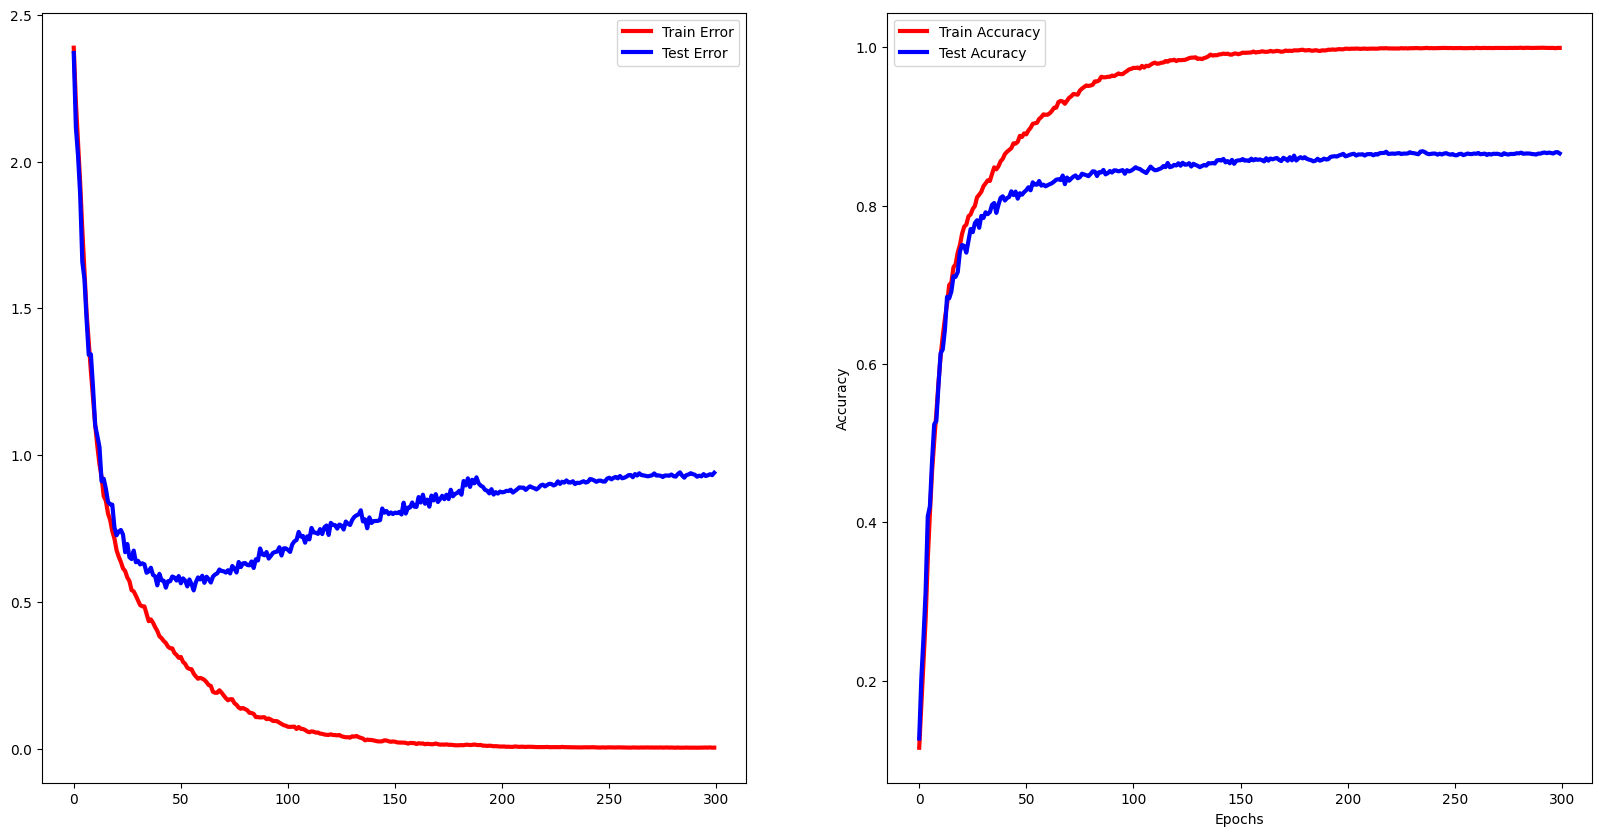

In [10]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error',color='Red')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error',color='Blue')

ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy',color='Red')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy',color='Blue')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

ax1.legend()
ax2.legend()
figure.savefig("./trainTestCurve.png")

In [11]:
corrects = 0.0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    output = torch.argmax(output, dim=1)
    corrects += torch.sum(labels == output).float().item()
print(corrects/len(test_loader.dataset))

0.8659


In [13]:
!pip install onnx
model = resnet_model()
model.load_state_dict(torch.load('./saved_model.pt'))
# set the model to evaluation mode 
model.eval() 

# Let's create a sample input tensor  
x = torch.randn(4, 3, 32, 32)

torch.onnx.export(model,x, "final_resnet_model.onnx",opset_version=10)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 74.9 MB/s eta 0:00:00


Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

